In [1]:
#| default_exp core

# Imports and Config

In [2]:
#| export

import ctypes
import clip
import concurrent
import cv2
import gc
import imagehash
import io
import kagglehub
import math
import numpy as np
import os
import pandas as pd
import random
import statistics
import string
import time
import transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
from cairosvg import svg2png
from DeepCache import DeepCacheSDHelper
from diffusers import AutoencoderTiny, DPMSolverMultistepScheduler, StableDiffusionXLPipeline
from more_itertools import chunked
from PIL import Image, ImageFilter

# Determinism
SEED = 0
# Models
KH_MODEL_DIFF0 = "conormacamhlaoibh/segmind-ssd-1b/transformers/default/1"
KH_MODEL_DIFF1 = "conormacamhlaoibh/segmind-ssd-1b/transformers/default/1"
KH_MODEL_VAE = "conormacamhlaoibh/madebyollin-taesd/transformers/default/2"
KH_MODEL_CLIP = "metric/openai-clip-vit-large-patch14"
KH_MODEL_AEST = "metric/sac-logos-ava1-l14-linearmse"
FILE_MODEL_CLIP = "ViT-L-14.pt"
FILE_MODEL_AEST = "sac+logos+ava1-l14-linearMSE.pth"
# GPUs
DEVICE_0 = torch.device("cuda:0")
DEVICE_1 = torch.device("cuda:1")
# Misc
LIBC = ctypes.CDLL("libc.so.6")
# Stable Diffusion
PROMPT_POS = (
    "flat vector illustration, clean shapes, hard color boundaries, solid fills, "
    "saturated flat colors, minimalist, simple classic style, stylized, aesthetic, beautiful, "
    "no shading, no blending, no background elements, "
    "style: vector clip art, small color palette, "
    "prompt: vector art of %s"
)
PROMPT_NEG = (
    "photorealistic, realistic, detailed, details, 3D, complex shading, gradients, soft edges, "
    "texture, painting, blurry, pixelated, thin lines, dots, text, signature, watermark, "
    "framing, picture frame, cropped border, hatching"
)

2026-02-11 12:17:46.080436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770812266.297107      44 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770812266.362369      44 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Basic Stuff

In [3]:
#| export

class AestheticMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(768, 1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.Dropout(0.1),
            nn.Linear(64, 16),
            nn.Linear(16, 1),
        )
    
    def forward(self, x):
        return self.layers(x)

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    transformers.set_seed(seed)

set_seed(SEED)
g0 = torch.Generator(device="cuda:0").manual_seed(SEED)
g1 = torch.Generator(device="cuda:1").manual_seed(SEED + 1)

def svg_to_image(svg):
    data_png = svg2png(bytestring=svg.encode("utf-8"))
    return Image.open(io.BytesIO(data_png)).convert("RGB").resize((384, 384))

# Adversarial SVG

In [4]:
#| export

STOPWORDS = [
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his",
    "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what",
    "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have",
    "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until",
    "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above",
    "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here",
    "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no",
    "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now",
]

ALPH = {
    "A": "M10,50 L30,10 L50,50 M20,35 L40,35",
    "B": "M10,10 L10,50 L35,50 L40,45 L40,35 L35,30 M10,30 L35,30 L40,25 L40,15 L35,10 L10,10",
    "C": "M40,10 L15,10 L10,15 L10,45 L15,50 L40,50",
    "D": "M10,10 L10,50 L30,50 L40,45 L40,15 L30,10 L10,10",
    "E": "M10,10 L40,10 M10,30 L30,30 M10,50 L40,50 L10,50 L10,10",
    "F": "M10,50 L10,10 L40,10 M10,30 L30,30",
    "G": "M40,10 L10,10 L10,50 L40,50 L40,30 L25,30",
    "H": "M10,10 L10,50 M40,10 L40,50 M10,30 L40,30",
    "I": "M25,10 L25,50",
    "J": "M20,10 L40,10 L40,45 L35,50 L15,50 L10,45",
    "K": "M10,10 L10,50 M40,10 L10,30 M40,50 L10,30",
    "L": "M10,10 L10,50 L40,50",
    "M": "M10,50 L10,10 L25,30 L40,10 L40,50",
    "N": "M10,50 L10,10 L40,50 L40,10",
    "O": "M10,10 L40,10 L40,50 L10,50 L10,10",
    "P": "M10,50 L10,10 L35,10 L35,30 L10,30",
    "Q": "M10,10 L40,10 L40,50 L10,50 L10,10 M25,35 L40,50",
    "R": "M10,50 L10,10 L35,10 L35,30 L10,30 M10,30 L35,50",
    "S": "M40,10 L15,10 L15,30 L35,30 L35,50 L10,50",
    "T": "M10,10 L40,10 M25,10 L25,50",
    "U": "M10,10 L10,50 L40,50 L40,10",
    "V": "M10,10 L25,50 L40,10",
    "W": "M10,10 L10,50 L25,30 L40,50 L40,10",
    "X": "M10,10 L40,50 M40,10 L10,50",
    "Y": "M10,10 L25,30 L40,10 M25,30 L25,50",
    "Z": "M10,10 L40,10 L10,50 L40,50",
    "0": "M10,10 L40,10 L40,50 L10,50 L10,10",
    "1": "M25,10 L25,50 M15,50 L35,50 M15,10 L25,10",
    "2": "M40,50 L10,50 L10,30 L40,30 L40,10 L10,10",
    "3": "M10,10 L40,10 L40,30 L10,30 M40,30 L40,50 L10,50",
    "4": "M40,50 L40,10 L10,30 L40,30",
    "5": "M40,10 L10,10 L10,30 L40,30 L40,50 L10,50",
    "6": "M40,10 L10,10 L10,50 L40,50 L40,30 L10,30",
    "7": "M10,10 L40,10 L25,50",
    "8": "M10,10 L40,10 L40,50 L10,50 L10,10 M10,30 L40,30",
    "9": "M10,50 L40,50 L40,10 L10,10 L10,30 L40,30",
    "-": "M10,30 L40,30",
    "!": "M25,10 L25,35 M25,45 L25,50"
}

SVG_BASE = """
<svg viewBox="0 0 384 384">
    <defs>
        <pattern id="a" x="0" y="0" width="10" height="10" patternUnits="userSpaceOnUse">
            <g opacity=".1">
                <path fill="#fff" d="M1 1h1v1H1z"/>
                <path fill="#ff0" d="M4 2h1v1H4z"/>
                <path fill="#0f0" d="M6 8h1v1H6z"/>
                <path fill="#00f" d="M9 5h1v1H9z"/>
            </g>
        </pattern>
    </defs>
    <rect width="100%" height="100%" fill="url(#a)"/>
</svg>
""".replace("    ", "").replace("\n", "")

SVG_RECTS = [
"""
<path fill="#000" d="M364 0h20v20h-20z"/>
<path fill="#501" d="M364 20h20v20h-20z"/>
<path fill="#000" d="M364 40h20v20h-20zm0 20h20v20h-20zm0 20h20v20h-20z"/>
<path fill="#101" d="M344 0h20v20h-20z"/>
<path fill="#622" d="M344 20h20v20h-20z"/>
<path fill="#000" d="M344 40h20v20h-20z"/>
<path fill="#5cf" d="M344 60h20v20h-20z"/>
<path fill="#000" d="M344 80h20v20h-20zM324 0h20v20h-20z"/>
<path fill="#ad3" d="M324 20h20v20h-20z"/>
<path fill="#000" d="M324 40h20v20h-20z"/>
<path fill="#bc5" d="M324 60h20v20h-20z"/>
<path fill="#001" d="M324 80h20v20h-20z"/>
<path fill="#000" d="M304 0h20v20h-20z"/>
<path fill="#6df" d="M304 20h20v20h-20z"/>
<path fill="#000" d="M304 40h20v20h-20z"/>
<path fill="#f33" d="M304 60h20v20h-20z"/>
<path fill="#301" d="M304 80h20v20h-20z"/>
""".replace("\n", ""),
"""
<path fill="#3ae" d="M364 0h20v20h-20z"/>
<path fill="#2cb" d="M364 20h20v20h-20z"/>
<path fill="#e02" d="M364 40h20v20h-20z"/>
<path fill="#000" d="M364 60h20v20h-20z"/>
<path fill="#8e2" d="M364 80h20v20h-20z"/>
<path fill="#3bd" d="M344 0h20v20h-20z"/>
<path fill="#389" d="M344 20h20v20h-20z"/>
<path fill="#e14" d="M344 40h20v20h-20z"/>
<path fill="#000" d="M344 60h20v20h-20z"/>
<path fill="#226" d="M344 80h20v20h-20z"/>
<path fill="#1fd" d="M324 0h20v20h-20z"/>
<path fill="#000" d="M324 20h20v20h-20z"/>
<path fill="#fb1" d="M324 40h20v20h-20z"/>
<path fill="#000" d="M324 60h20v20h-20z"/>
<path fill="#48c" d="M324 80h20v20h-20z"/>
<path fill="#48f" d="M304 0h20v20h-20z"/>
<path fill="#000" d="M304 20h20v20h-20z"/>
<path fill="#c12" d="M304 40h20v20h-20z"/>
<path fill="#000" d="M304 60h20v20h-20z"/>
<path fill="#5ef" d="M304 80h20v20h-20z"/>
""".replace("\n", ""),
"""
<path fill="#000" d="M364 0h20v20h-20z"/>
<path fill="#501" d="M364 20h20v20h-20z"/>
<path fill="#000" d="M364 40h20v20h-20zm0 20h20v20h-20zm0 20h20v20h-20z"/>
<path fill="#101" d="M344 0h20v20h-20z"/>
<path fill="#622" d="M344 20h20v20h-20z"/>
<path fill="#000" d="M344 40h20v20h-20z"/>
<path fill="#7fe" d="M344 60h20v20h-20z"/>
<path fill="#000" d="M344 80h20v20h-20zM324 0h20v20h-20z"/>
<path fill="#ad3" d="M324 20h20v20h-20z"/>
<path fill="#000" d="M324 40h20v20h-20z"/>
<path fill="#f82" d="M324 60h20v20h-20z"/>
<path fill="#001" d="M324 80h20v20h-20z"/>
<path fill="#000" d="M304 0h20v20h-20z"/>
<path fill="#6df" d="M304 20h20v20h-20z"/>
<path fill="#101" d="M304 40h20v20h-20z"/>
<path fill="#e21" d="M304 60h20v20h-20z"/>
<path fill="#301" d="M304 80h20v20h-20z"/>
""".replace("\n", ""),
"""
<path fill="#77e" d="M364 0h20v20h-20z"/>
<path fill="#eb3" d="M364 20h20v20h-20z"/>
<path fill="#b3e" d="M364 40h20v20h-20z"/>
<path fill="#37c" d="M364 60h20v20h-20z"/>
<path fill="#2de" d="M364 80h20v20h-20z"/>
<path fill="#55b" d="M344 0h20v20h-20z"/>
<path fill="#ea3" d="M344 20h20v20h-20z"/>
<path fill="#93a" d="M344 40h20v20h-20z"/>
<path fill="#000" d="M344 60h20v20h-20zm0 20h20v20h-20z"/>
<path fill="#338" d="M324 0h20v20h-20z"/>
<path fill="#a62" d="M324 20h20v20h-20z"/>
<path fill="#105" d="M324 40h20v20h-20z"/>
<path fill="#86f" d="M324 60h20v20h-20z"/>
<path fill="#a8a" d="M324 80h20v20h-20z"/>
<path fill="#be1" d="M304 0h20v20h-20z"/>
<path fill="#000" d="M304 20h20v20h-20zm0 20h20v20h-20zm0 20h20v20h-20z"/>
<path fill="#2ef" d="M304 80h20v20h-20z"/>
""".replace("\n", "")
]

SVG_TEXT = """
<path d="M17 25h20L17 52h20m10-27h20v27H47V25m30 0v27m20-27L77 39m20 13L77 39" stroke-width="4" stroke="#fff" fill="none"/>
<path d="M319 138h-16v14h13v13h-17m43-27h-16v14h13v13h-17m23-27h20v27h-20v-27m10 17 10 10" stroke-width="4" stroke="#333" fill="none"/>
<path d="M16 137h20v14H16m20 0v13H16m30-27h20v27H46v-27m10 17 10 10m10-27h20v14H76m20 0v13H76M16 86v27m20-27-20 14m20 13-20-13m30-14v27h20V86m10 0h20l-20 27h20" stroke-width="4" stroke="#242" fill="none"/>
""".replace("\n", "")

SVG_FINAL_TEXT = """
<path d="M19 365v-22h17m-17 11h11m14 11v-22h14v11H44m0 0 14 11m11 0 11-22 11 22m-16-8h11m8 8v-22l17 22v-22m25 0h-14l-3 3v17l3 2h14m8-22h17m-17 11h11m-11 11h17-17v-22m50 0 17 22m0-22-17 22m25-22v22m17-22-17 11m17 11-17-11m50 11 11-22 11 22m-16-8h11m8 8v-22h14v11h-14m0 0 14 11m11-22h17m-9 0v22m34-22h-14v11h11v11h-14" stroke-width="2.5" stroke="#242" fill="none"/>
""".replace("\n", "")

def add_text_to_svg(
    svg_base,
    text,
    color_bg="none",
    color_fg="#fff",
    max_chars_word=12,
    max_chars_all=12,
    ox=40,
    oy=30,
    w=17,
    h=23,
    scale_f=2.5,
    stroke_w=4,
):
    text = text.upper()
    cx, cy = 0, 0
    paths = []
    svg_text = f'<g stroke-width="{stroke_w}" stroke="{color_fg}" fill="{color_bg}">'
    for word in text.split(" "):
        if cx > 0 and cx + len(word) > max_chars_word:
            cx = 0
            cy += 1
        for char in word:
            if char in ALPH:
                x = ox + (cx * w)
                y = oy + (cy * h)
                ds = []
                for inst in ALPH[char].split():
                    a = inst[0]
                    b, c = map(lambda x: int(int(x) / scale_f), inst[1:].split(","))
                    ds.append(f"{a}{b+x},{c+y}")
                d = "".join(ds)
                path = f'<path d="{d}"/>'
                paths.append(path)
            if char == "\n":
                cx = 0
                cy += 1
            else:
                cx += 1
                if cx > max_chars_all:
                    cx = 0
                    cy += 1
        cx += 1
    for path in paths:
        if len(svg_base) + len(svg_text) + len(path) > 9950:
            break
        svg_text += path
    svg_text += '</g>'
    return svg_base[:-6] + svg_text + svg_base[-6:]

def get_fallback_svg(prompt, keywords_only=False):
    if keywords_only:
        prompt = " ".join([word for word in prompt.split() if word not in STOPWORDS])
    svg_rects = """
<rect x="364" y="280" width="20" height="20" fill="#4db"/>
<rect x="364" y="300" width="20" height="20" fill="#7d0"/>
<rect x="364" y="320" width="20" height="20" fill="#f31"/>
<rect x="364" y="340" width="20" height="20" fill="#901"/>
<rect x="364" y="360" width="20" height="20" fill="#f00"/>
<rect x="344" y="280" width="20" height="20" fill="#000"/>
<rect x="344" y="300" width="20" height="20" fill="#000"/>
<rect x="344" y="320" width="20" height="20" fill="#7b3"/>
<rect x="344" y="340" width="20" height="20" fill="#000"/>
<rect x="344" y="360" width="20" height="20" fill="#af2"/>
""".replace("\n", "")
    svg_adv = SVG_BASE
    svg_adv_body = svg_adv[svg_adv.index(">") + 1:-6]
    svg = f'<svg viewBox="0 0 384 384">{svg_adv_body}{svg_rects}</svg>'
    svg = add_text_to_svg(svg, "ZOK", color_fg="#fff", scale_f=1.5, ox=10, oy=10, w=30, h=30)
    svg = add_text_to_svg(svg, "SSQ", color_fg="#333", scale_f=1.5, ox=293, oy=10, w=23, h=30)
    svg = add_text_to_svg(svg, f"illustration of {prompt}\namazing europe oil art europe", color_fg="#900", stroke_w=3, scale_f=1.55, ox=10, oy=50, w=28, h=37)
    return svg

def text_to_lines(text, max_line_length=13):
    text = "".join([char if char in ALPH else " " for char in text.upper()])
    lines = []
    line = ""
    for word in text.split(" "):
        if len(word) > max_line_length:
            if len(line): lines.append(line)
            lines.append(word)
            line = ""
        elif len(line) + len(word) >= max_line_length:
            lines.append(line)
            line = word
        else:
            if len(line): line += " "
            line += word
    if len(line): lines.append(line)
    return lines

def compress_paths(paths, space_free):
    x0, y0 = paths[0][0][1:]
    path = f"m{x0} {y0} "
    cmd_prev = "l"
    for i, _path in enumerate(paths):
        j = 0 if i > 0 else 1
        for act_cmd, x1, y1 in _path[j:]:
            path_last = path
            act_cmd = act_cmd.lower()
            dx, dy = x1 - x0, y1 - y0
            if act_cmd == "m":
                if cmd_prev != "m":
                    path = path.rstrip() + "m"
                path += str(dx)
                if dy >= 0: path += " "
                path += str(dy)
                cmd_prev = "m"
            else:
                cmd = "l"
                if dx == 0: cmd = "v"
                elif dy == 0: cmd = "h"
                if cmd != cmd_prev:
                    path = path.rstrip() + cmd
                    cmd_prev = cmd
                if cmd == "v":
                    path += str(dy) + " "
                elif cmd == "h":
                    path += str(dx) + " "
                else:
                    if dx < 0: path = path.rstrip()
                    path += str(dx)
                    if dy > 0: path += " "
                    path += str(dy) + " "
            x0, y0 = x1, y1
            if len(path) > space_free:
                return path_last
        path = path.rstrip()
    return path

def add_compressed_text_to_svg(svg_base, text, max_line_length=13, max_n_lines=6, color="#444", stroke_w=4, scale_f=1.8, off_x=10, off_y=180, char_w=28, char_h=37):
    lines = text_to_lines(text, max_line_length=max_line_length)
    lines = [line[:max_line_length] for line in lines[:max_n_lines]]
    
    paths = []
    cursor_y = 0
    for line in lines:
        cursor_x = 0
        for char in line:
            if char in ALPH:
                x = off_x + (cursor_x * char_w)
                y = off_y + (cursor_y * char_h)
                path = []
                for inst in ALPH[char].split():
                    cmd = inst[0]
                    _x, _y = map(lambda x: int(int(x) / scale_f), inst[1:].split(","))
                    act_x = x + _x
                    act_y = y + _y
                    path.append([cmd, act_x, act_y])
                paths.append(path)
            cursor_x += 1
        cursor_y += 1

    svg_path_pre = f'<path d="'
    svg_path_suf = f'" stroke-width="{stroke_w}" stroke="{color}" fill="none"/>'
    space_free = 9990 - (len(svg_base) + len(svg_path_pre) + len(svg_path_suf))
    comp_d = compress_paths(paths, space_free)
    svg_text = svg_base[:-6] + svg_path_pre + comp_d + svg_path_suf + svg_base[-6:]

    return svg_text, len(lines) < 5

def combine_svg_with_adversarial(svg_img, prompt):
    prompt = " ".join([word for word in prompt.split() if word not in STOPWORDS])    
    svg_adv = SVG_BASE
    svg_adv_body = svg_adv[svg_adv.index(">") + 1:-6]
    svg_img_body = svg_img[svg_img.index(">") + 1:-6]
    svgs = []
    for SVG_RECT in SVG_RECTS:
        svg = f'<svg viewBox="0 0 384 384">{svg_adv_body}<g transform="scale(0.4) translate(300, 30)">{svg_img_body}</g>{SVG_RECT}{SVG_TEXT}</svg>'
        svg, last_line_free = add_compressed_text_to_svg(svg, prompt, max_n_lines=5)
        if last_line_free and len(svg) + len(SVG_FINAL_TEXT) < 10000:
            svg = svg[:-6] + SVG_FINAL_TEXT + svg[-6:]
        svgs.append(svg)
    return svgs

# Fast Image Processor

In [5]:
#| export

fft_mask_cache = {}
def ipf_fft_mask(h, w, cutoff):
    key = (h, w, cutoff)
    if key not in fft_mask_cache:
        cr, cc = h // 2, w // 2
        r = int(min(cr, cc) * cutoff)
        y, x = np.ogrid[:h, :w]
        mask = (((y - cr) ** 2) + ((x - cc) ** 2) <= r * r).astype(np.float32)
        fft_mask_cache[key] = mask
    return fft_mask_cache[key]

def ipf_jpeg(arr, quality=85):
    _, enc = cv2.imencode(
        ".jpg",
        cv2.cvtColor(arr, cv2.COLOR_RGB2BGR),
        [int(cv2.IMWRITE_JPEG_QUALITY), quality, int(cv2.IMWRITE_JPEG_OPTIMIZE), 1]
    )
    dec = cv2.imdecode(enc, cv2.IMREAD_COLOR)
    return cv2.cvtColor(dec, cv2.COLOR_BGR2RGB)
    
def ipf_median(arr, size=3):
    return cv2.medianBlur(arr, ksize=size)

def ipf_bilateral(arr, d=9, sigma_color=75, sigma_space=75):
    return cv2.bilateralFilter(arr, d, sigma_color, sigma_space)

def ipf_fft(arr, cutoff=0.5):
    arr = arr.astype(np.float32)
    f = np.fft.fft2(arr, axes=(0, 1))
    fshift = np.fft.fftshift(f, axes=(0, 1))
    mask = ipf_fft_mask(*arr.shape[:2], cutoff)
    fshift *= mask[:,:,None]
    img_back = np.fft.ifft2(np.fft.ifftshift(fshift, axes=(0, 1)), axes=(0, 1))
    return np.clip(img_back.real, 0, 255).astype(np.uint8)

def ipf_crop_resize(arr, crop_percent=0.03):
    h, w = arr.shape[:2]
    cpw, cph = int(w * crop_percent), int(h * crop_percent)
    left = np.random.randint(0, cpw + 1)
    top = np.random.randint(0, cph + 1)
    right = w - np.random.randint(0, cpw + 1)
    bottom = h - np.random.randint(0, cph + 1)
    crop = arr[top:bottom, left:right]
    return cv2.resize(crop, (w, h), interpolation=cv2.INTER_LINEAR)

def process_image(image):
    arr = np.asarray(image)
    arr = ipf_crop_resize(arr, crop_percent=0.03)
    arr = ipf_jpeg(arr, quality=95)
    arr = ipf_median(arr, size=9)
    arr = ipf_fft(arr, cutoff=0.5)
    arr = ipf_bilateral(arr, d=5, sigma_color=75, sigma_space=75)
    arr = ipf_jpeg(arr, quality=92)
    return Image.fromarray(arr)

# Image to SVG Conversion

In [6]:
#| export

def rgb_to_hex(rgb):
    return "#" + f"{rgb[0]:02x}{rgb[1]:02x}{rgb[2]:02x}"[::2]

def points_to_path(points):
    x0, y0 = points[0]
    path = f"m{x0} {y0} "
    cmd_prev = "l"
    for x1, y1 in points[1:]:
        dx, dy = x1 - x0, y1 - y0
        if dx == 0: cmd = "v"
        elif dy == 0: cmd = "h"
        else: cmd = "l"
        if cmd != cmd_prev:
            path = path.rstrip() + cmd
            cmd_prev = cmd
        if cmd == "v":
            path += str(dy) + " "
        elif cmd == "h":
            path += str(dx) + " "
        else:
            if dx < 0: path = path.rstrip()
            path += str(dx)
            if dy > 0: path += " "
            path += str(dy) + " "
        x0, y0 = x1, y1
    path = path.rstrip() + "z"
    return path

def image_to_svg(image, f_downsample=2, max_size=6000, n_colors=6, min_area=1.0, eps_ratio=0.01):
    h, w = image.size
    if f_downsample > 1:
        h //= f_downsample
        w //= f_downsample

    q = image.resize((h, w), Image.BILINEAR).quantize(colors=n_colors, method=Image.MEDIANCUT)
    palette = np.asarray(q.getpalette(), dtype=np.uint8).reshape(-1, 3)[:n_colors]
    labels = np.asarray(q, dtype=np.uint8)
    cx, cy = w / 2, h / 2

    feats = []
    for idx, rgb in enumerate(palette):
        mask = (labels == idx)
        if not mask.any():
            continue
        mask = mask.astype(np.uint8) * 255
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            continue
        for contour in contours:
            area = cv2.contourArea(contour)
            if area < min_area:
                continue
            M = cv2.moments(contour)
            if M["m00"] == 0:
                continue
            dx = (M["m10"] / M["m00"] - cx) / w
            dy = (M["m01"] / M["m00"] - cy) / h
            dist = ((dx * dx) + (dy * dy)) ** 0.5
            
            eps = eps_ratio * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, eps, True)
            pnts = approx.reshape(-1, 2)
            pnt_str = points_to_path([
                [int(x * f_downsample), int(y * f_downsample)]
                for x, y in pnts
            ])

            imp = area * (1 - dist) / (len(pnts) + 1)
            feats.append((imp, pnt_str, rgb_to_hex(rgb)))
    feats.sort(reverse=True)
    
    bg_hex = rgb_to_hex(palette[labels[0, 0]])
    h_svg, w_svg = h * f_downsample, w * f_downsample
    svg = [f'<svg viewBox="0 0 {w_svg} {h_svg}"><path fill="{bg_hex}" d="M0 0h{w_svg}v{h_svg}H0z"/>']
    size = len(svg[0]) + len('</svg>')
    
    for _, pnt_str, col_hex in feats:
        path_str = f'<path fill="{col_hex}" d="{pnt_str}"/>'
        size_poly = len(path_str)
        if size + size_poly > max_size:
            break
        svg.append(path_str)
        size += size_poly

    svg.append('</svg>')
    return "".join(svg)

# Model

In [7]:
#| export

TIMEOUT_ALL = 32040 # 8.9 hours

class Model:
    def __init__(self, verbose=False):
        self.verbose = verbose
        if self.verbose: print(f"[*] Loading models...")
        self.time_start = time.time()
        self.path_model_diff0 = kagglehub.model_download(KH_MODEL_DIFF0)
        self.path_model_diff1 = kagglehub.model_download(KH_MODEL_DIFF1)
        self.path_model_vae = kagglehub.model_download(KH_MODEL_VAE)
        self.path_model_clip = os.path.join(kagglehub.notebook_output_download(KH_MODEL_CLIP), FILE_MODEL_CLIP)
        self.path_model_aest = os.path.join(kagglehub.notebook_output_download(KH_MODEL_AEST), FILE_MODEL_AEST)
        self.model_diff0 = self.__load_model_diff(self.path_model_diff0,DEVICE_0)
        self.model_diff1 = self.__load_model_diff(self.path_model_diff1,DEVICE_1)
        self.model_clip, self.proc_clip, self.model_aest = self.__load_model_clip_and_aest()
        if self.verbose: print(f"[+] Loaded models in {time.time() - self.time_start:.1f}s")

    def __load_model_diff(self,path_model_diff,device):
        model_diff = StableDiffusionXLPipeline.from_pretrained(
            path_model_diff,
            local_files_only=True,
            use_safetensors=True,
            torch_dtype=torch.float16,
            variant="fp16",
        )
        model_diff.vae = AutoencoderTiny.from_pretrained(
            self.path_model_vae,
            local_files_only=True,
            use_safetensors=True,
            torch_dtype=torch.float16,
        )
        model_diff.to(device)
        torch.backends.cuda.matmul.allow_tf32 = True
        model_diff.scheduler = DPMSolverMultistepScheduler.from_config(model_diff.scheduler.config)
        helper = DeepCacheSDHelper(pipe=model_diff)
        helper.set_params(cache_interval=2, cache_branch_id=0)
        helper.enable()
        return model_diff
        
    def __load_model_clip_and_aest(self):
        model_clip, proc_clip = clip.load(self.path_model_clip, device=DEVICE_0)
        model_clip.eval()
        state_dict = torch.load(self.path_model_aest, weights_only=True, map_location=DEVICE_0)
        model_aest = AestheticMLP()
        model_aest.load_state_dict(state_dict)
        model_aest.eval()
        model_aest.to(DEVICE_0)
        return model_clip, proc_clip, model_aest
        
    def generate_images(
        self,
        prompt: str,
        num_inference_steps: int = 12,
        guidance_scale: float = 8.0,
        num_images_per_prompt: int = 20,
        batch_size: int = 20,
    ):
        images0 = self.model_diff0(
            prompt=PROMPT_POS % prompt,
            negative_prompt=PROMPT_NEG,
            height=384,
            width=384,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            num_images_per_prompt=num_images_per_prompt//2,
            batch_size=batch_size,
            generator=g0
        ).images
        images1 = self.model_diff1(
            prompt=PROMPT_POS % prompt,
            negative_prompt=PROMPT_NEG,
            height=384,
            width=384,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            num_images_per_prompt=num_images_per_prompt//2,
            batch_size=batch_size,
            generator=g1
        ).images
        imgs = images0 + images1
        return imgs
        
    def get_best_image_idx(self, svgs, images, n_copies=1, batch_size=20):
        scores = []
        tensors = [self.proc_clip(image).to(DEVICE_0) for image in images]
        n_chunks = math.ceil(len(tensors) / batch_size)
        with torch.no_grad():
            for i in range(n_chunks):
                batch = tensors[(i * batch_size):((i + 1) * batch_size)]
                x = torch.stack(batch, dim=0)
                feats = self.model_clip.encode_image(x)
                feats = F.normalize(feats, dim=-1).float()
                preds = self.model_aest(feats).squeeze(1) / 10.0
                scores.extend(preds.cpu().tolist())
        n_unique = len(scores) // n_copies
        scores = np.array(scores).reshape(n_unique, n_copies)
        mean_scores = np.mean(scores, axis=1).tolist()
        best_idx = 0
        best_score, best_score_real = 0.0, 0.0
        for i, _score in enumerate(mean_scores):
            penalty = 0.0
            score = _score - penalty
            if score > best_score:
                best_score = score
                best_score_real = _score
                best_idx = i
        return best_idx, best_score_real
    
    def predict_generative(self, prompt):
        if self.verbose: print(f"[*] Running for prompt '{prompt}'...")
        t0 = time.time()
        # GENERATE IMAGES
        images_diff = self.generate_images(prompt, num_inference_steps=12, guidance_scale=8.0, num_images_per_prompt=64, batch_size=32)
        t1 = time.time()
        if self.verbose: print(f"[-] Generated {len(images_diff)} images in {t1 - t0:.1f}s (total = {t1 - t0:.1f}s)")
        # EXTRACT SVG
        svgs = [
            image_to_svg(image_diff, f_downsample=2, max_size=6000, n_colors=6, min_area=1.0, eps_ratio=0.01)
            for image_diff in images_diff
        ]
        t2 = time.time()
        if self.verbose: print(f"[-] Extracted {len(svgs)} SVGs in {t2 - t1:.1f}s  (total = {t2 - t0:.1f}s)")
        # COMBINE WITH ADVERSARIAL METHOD
        _svgs = []
        for svg in svgs:
            _svgs.extend(combine_svg_with_adversarial(svg, prompt))
        svgs = _svgs
        svgs = [
            svg for svg in svgs if len(svg) <= 10000
        ]
        t3 = time.time()
        if self.verbose: print(f"[-] Combined with adversarial method in {t3 - t2:.1f}s  (total = {t3 - t0:.1f}s)")
        # CONVERT + PROCESS IMAGES
        images_proc = [process_image(svg_to_image(svg)) for svg in svgs]
        t4 = time.time()
        if self.verbose: print(f"[-] Converted and processed {len(images_proc)} images in {t4 - t3:.1f}s  (total = {t4 - t0:.1f}s)")
        # EVALUATE SVGS
        idx, max_aest = self.get_best_image_idx(svgs, images_proc, batch_size=64)
        t5 = time.time()
        if self.verbose: print(f"[-] Evaluated {len(images_proc)} images in {t5 - t4:.1f}s  (total = {t5 - t0:.1f}s)")
        if self.verbose: print(f"[+] Best mean aesthetic score: {max_aest:.3f}")
        svg = svgs[idx]
        if self.verbose: print(f"[+] SVG Length: {len(svg)}")

        del svgs
        del images_diff
        del images_proc
        gc.collect()
        torch.cuda.empty_cache()
        
        if len(svg) > 10000:
            raise Exception(f"SVG too large ({len(svg)})")
        return svg
    
    def predict(self, prompt):
        if time.time() - self.time_start > TIMEOUT_ALL:
            if self.verbose: print(f"[!] Global timeout")
            return get_fallback_svg(prompt)
        try:
            svg = self.predict_generative(prompt)
            if self.verbose: print(f"[+] Returning generated SVG")
            return svg
        except Exception as e:
            if self.verbose: print(f"[!] Exception occurred: '{e}'")
            return get_fallback_svg(prompt)

In [8]:
model = Model(verbose=True)
svg = model.predict("a purple forest at dusk")
img0 = svg_to_image(svg)
img1 = process_image(img0)

[*] Loading models...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[+] Loaded models in 51.2s
[*] Running for prompt 'a purple forest at dusk'...


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

[-] Generated 64 images in 25.2s (total = 25.2s)
[-] Extracted 64 SVGs in 2.7s  (total = 27.9s)
[-] Combined with adversarial method in 0.1s  (total = 28.0s)
[-] Converted and processed 256 images in 22.8s  (total = 50.7s)
[-] Evaluated 256 images in 3.5s  (total = 54.2s)
[+] Best mean aesthetic score: 0.611
[+] SVG Length: 8354
[+] Returning generated SVG


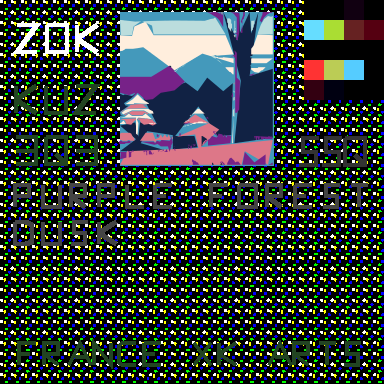

In [9]:
img0

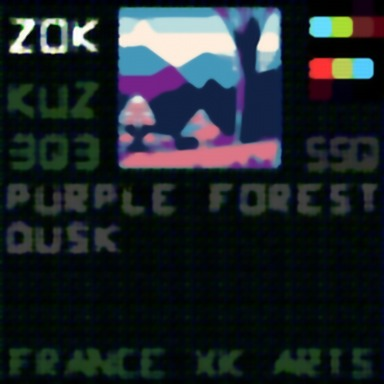

In [10]:
img1

In [11]:
print(svg)

<svg viewBox="0 0 384 384"><defs><pattern id="a" x="0" y="0" width="10" height="10" patternUnits="userSpaceOnUse"><g opacity=".1"><path fill="#fff" d="M1 1h1v1H1z"/><path fill="#ff0" d="M4 2h1v1H4z"/><path fill="#0f0" d="M6 8h1v1H6z"/><path fill="#00f" d="M9 5h1v1H9z"/></g></pattern></defs><rect width="100%" height="100%" fill="url(#a)"/><g transform="scale(0.4) translate(300, 30)"><path fill="#49b" d="M0 0h384v384H0z"/><path fill="#124" d="m258 0 44 172-16 156 96-14v-172l-58 18 22-160-18 54-4-54-24 52-2-52-4 72z"/><path fill="#124" d="m282 178-24 20-40-34-24 34-30-22-106 38 34 66-42-4-4 36-8-36-38 8 40 34-40 30h120l-68-20 16-30 64 10v36l62-6-8-28h-48l58-74 48 74 34-2z"/><path fill="#fed" d="m0 58v40l58-10 78 58 70-42 78 24v-12l-54-6 54-4-20-48h-180l-20-34-28 12-6 24z"/><path fill="#d78" d="m0 382h304l8-34 58 34 12-62-180 18 46-44-60-38-30 22h64l-80 34 46-6 8 34-178 8z"/><path fill="#49b" d="m134 148 58 48 26-34h14l28 34 24-34-24-22-90-2 114-6h-28l-28-20-26-4z"/><path fill="#bdd" d="m2